# 1. Import Packages and Saved Data 

In [ ]:
# %%writefile utils/my_utils.py

# Installation
# !python -m spacy download en_core_web_sm (# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER))
# !pip install scikit-learn
# !pip install textblob
# %pip install optuna (# Unlike !pip, %pip installs into the current Jupyter kernel's environment reliably)
# %pip install imblearn
# %pip install --upgrade optuna
# %pip install xgboost lightgbm
# %pip install shap

# Standard libraries
import os, io, datetime, sys, json
from tqdm import tqdm
import joblib
from pathlib import Path


# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Split to training and testing datasets
from sklearn.model_selection import train_test_split

# Feature scaling
from sklearn.preprocessing import PowerTransformer

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import sklearn
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import shap

#  Natural Language Processing (NLP)
import re, string
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nlt

True

In [3]:
session_data = joblib.load("Saved/tfidf_session_1.joblib")
df = session_data['df']
tfidf_df = session_data['tfidf_df']
tfidf_combined = session_data['tfidf_combined']
tfidf_vectorizer = session_data['tfidf_vectorizer']

c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
print(df.isnull().sum())

subject_id                  0
hadm_id                     0
stay_id                     0
admittime                   0
dischtime                   0
intime                      0
outtime                     0
note_id                     0
text                        0
length_of_icu_stay          0
admit_to_disch              0
length_of_icu_stay_hours    0
admit_to_disch_hours        0
note_length                 0
word_count                  0
spacy_lemmas                0
advanced_spacy_lemmas       0
spacy_lemmas_n              0
advanced_spacy_lemmas_n     0
lemma_text                  0
dtype: int64


In [4]:
df.shape

(10000, 20)

In [5]:
print(tfidf_df.isnull().sum())

ab           0
abd          0
abd soft     0
abdoman      0
abdomen      0
            ..
yellow       0
yes          0
yesterday    0
yo           0
zosyn        0
Length: 2000, dtype: int64


In [6]:
tfidf_df.shape

(10000, 2000)

In [7]:
print(tfidf_combined.isnull().sum())

subject_id               0
hadm_id                  0
stay_id                  0
admittime                0
dischtime                0
                      ... 
yo                       0
zosyn                    0
next_admittime        9238
days_to_next_admit    9238
readmit_30days           0
Length: 2023, dtype: int64


In [8]:
tfidf_combined.shape

(10000, 2023)

In [9]:
tfidf_combined['readmit_30days'].value_counts()

readmit_30days
0    9890
1     110
Name: count, dtype: int64

In [10]:
# Count how many admissions per subject
row_counts = tfidf_combined['subject_id'].value_counts()

# Subjects with only 1 row
subjects_with_1r = row_counts[row_counts == 1]
# Subjects with 2 rows
subjects_with_2r = row_counts[row_counts == 2]
# Subjects with 3 or more rows
subjects_with_3plusr = row_counts[row_counts >= 3]

print(f"Subjects with only 1 row: {len(subjects_with_1r)}")
print(f"Subjects with 2 rows: {len(subjects_with_2r)}")
print(f"Subjects with 3+ rows: {len(subjects_with_3plusr)}")

Subjects with only 1 row: 8615
Subjects with 2 rows: 524
Subjects with 3+ rows: 99


This counts the number of rows per subject_id, not the number of distinct hospital admissions (hadm_id). The expected number of null values in the columns next_admittime and days_to_next_admit is 9,238 ( could be calculated as 8,615 + 524 + 99).

In [11]:
admit_counts = tfidf_combined.groupby('subject_id')['hadm_id'].nunique()
subjects_with_1 = admit_counts[admit_counts == 1]
subjects_with_2 = admit_counts[admit_counts == 2]
subjects_with_3plus = admit_counts[admit_counts >= 3]

print(f"Subjects with only 1 admission: {len(subjects_with_1)}")
print(f"Subjects with 2 admissions: {len(subjects_with_2)}")
print(f"Subjects with 3+ admissions: {len(subjects_with_3plus)}")


Subjects with only 1 admission: 8732
Subjects with 2 admissions: 429
Subjects with 3+ admissions: 77


The expected number of null values in the columns next_admittime and days_to_next_admit is 9,238 (could be calculated as 8,732 + 429 + 77).

In [12]:
tfidf_combined.admit_to_disch_hours.isnull().sum()

0

# 2. Data Cleaning

## 2.1 Filter DataFrames to Remove Readmission Records

In [13]:
print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'intime',
       'outtime', 'note_id', 'text', 'length_of_icu_stay', 'admit_to_disch',
       'length_of_icu_stay_hours', 'admit_to_disch_hours', 'note_length',
       'word_count', 'spacy_lemmas', 'advanced_spacy_lemmas', 'spacy_lemmas_n',
       'advanced_spacy_lemmas_n', 'lemma_text'],
      dtype='object')


In [14]:
struc_data_cols = list(df.drop(columns=['text', 'spacy_lemmas', 'advanced_spacy_lemmas', 'lemma_text' ]).columns)
print(struc_data_cols)

['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'intime', 'outtime', 'note_id', 'length_of_icu_stay', 'admit_to_disch', 'length_of_icu_stay_hours', 'admit_to_disch_hours', 'note_length', 'word_count', 'spacy_lemmas_n', 'advanced_spacy_lemmas_n']


In [15]:
struc_data = tfidf_combined[struc_data_cols + ['readmit_30days']]

In [16]:
struc_data.head(10)

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,length_of_icu_stay,admit_to_disch,length_of_icu_stay_hours,admit_to_disch_hours,note_length,word_count,spacy_lemmas_n,advanced_spacy_lemmas_n,readmit_30days
7793,10000032,29079034,39553978,2180-07-23 12:35:00,2180-07-25 17:55:00,2180-07-23 14:00:00,2180-07-23 23:50:47,10000032-DS-23,0 days 09:50:47,2 days 05:20:00,9.846389,53.333333,10608,1633,862,862,0
774,10001725,25563031,31205490,2110-04-11 15:08:00,2110-04-14 15:00:00,2110-04-11 15:52:22,2110-04-12 23:59:56,10001725-DS-12,1 days 08:07:34,2 days 23:52:00,32.126111,71.866667,12107,1828,1032,1031,0
5154,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-11 04:20:05,2131-01-20 08:27:30,10001884-DS-38,9 days 04:07:25,12 days 08:36:00,220.123611,296.600000,9303,1371,767,767,0
4525,10002428,28662225,33987268,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-12 16:24:18,2156-04-17 15:57:08,10002428-DS-16,4 days 23:32:50,17 days 02:10:00,119.547222,410.166667,18547,2768,1711,1710,1
4128,10002428,23473524,35479615,2156-05-11 14:49:00,2156-05-22 14:16:00,2156-05-11 14:49:34,2156-05-22 14:16:46,10002428-DS-18,10 days 23:27:12,10 days 23:27:00,263.453333,263.450000,17123,2537,1451,1450,0
567,10002930,25922998,35629889,2198-04-17 19:38:00,2198-04-22 16:02:00,2198-04-17 21:24:00,2198-04-18 13:41:43,10002930-DS-12,0 days 16:17:43,4 days 20:24:00,16.295278,116.400000,9599,1415,813,814,0
8245,10004235,24181354,34100191,2196-02-24 14:38:00,2196-03-04 14:02:00,2196-02-24 17:07:00,2196-02-29 15:58:02,10004235-DS-21,4 days 22:51:02,8 days 23:24:00,118.850556,215.400000,19755,2910,1711,1713,0
499,10004401,23920883,32743332,2144-04-21 20:29:00,2144-05-01 13:00:00,2144-04-21 20:49:00,2144-05-01 13:53:03,10004401-DS-31,9 days 17:04:03,9 days 16:31:00,233.067500,232.516667,21048,3063,1748,1748,0
8551,10004422,21255400,32155744,2111-01-15 14:55:00,2111-01-25 15:00:00,2111-01-17 09:44:50,2111-01-23 18:18:46,10004422-DS-19,6 days 08:33:56,10 days 00:05:00,152.565556,240.083333,7803,1210,717,716,0
2779,10006580,24159665,38329661,2137-08-10 11:00:00,2137-08-15 13:25:00,2137-08-10 16:23:10,2137-08-11 13:56:56,10006580-DS-21,0 days 21:33:46,5 days 02:25:00,21.562778,122.416667,6651,1043,599,599,0


In [17]:
# Count number of unique hadm_ids per subject_id
hadm_counts = struc_data.groupby('subject_id')['hadm_id'].nunique()
hadm_counts.head()

subject_id
10000032    1
10001725    1
10001884    1
10002428    2
10002930    1
Name: hadm_id, dtype: int64

In [18]:
print(type(hadm_counts))

<class 'pandas.core.series.Series'>


In [19]:
# Get subject_ids that have more than one hadm_id
readm_subjects = hadm_counts[hadm_counts > 1].index
sigadm_subjects = hadm_counts[hadm_counts == 1].index

In [20]:
readm_struc_data = struc_data[struc_data['subject_id'].isin(readm_subjects)]

In [21]:
readm_struc_data.head(10)

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,length_of_icu_stay,admit_to_disch,length_of_icu_stay_hours,admit_to_disch_hours,note_length,word_count,spacy_lemmas_n,advanced_spacy_lemmas_n,readmit_30days
4525,10002428,28662225,33987268,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-12 16:24:18,2156-04-17 15:57:08,10002428-DS-16,4 days 23:32:50,17 days 02:10:00,119.547222,410.166667,18547,2768,1711,1710,1
4128,10002428,23473524,35479615,2156-05-11 14:49:00,2156-05-22 14:16:00,2156-05-11 14:49:34,2156-05-22 14:16:46,10002428-DS-18,10 days 23:27:12,10 days 23:27:00,263.453333,263.450000,17123,2537,1451,1450,0
4818,10020740,23831430,35889503,2150-03-11 15:34:00,2150-04-25 13:50:00,2150-03-25 18:22:56,2150-03-28 22:20:47,10020740-DS-17,3 days 03:57:51,44 days 22:16:00,75.964167,1078.266667,23272,3576,2047,2044,0
9526,10020740,25826145,32145159,2150-06-03 20:12:00,2150-06-07 15:05:00,2150-06-03 20:12:32,2150-06-04 21:05:58,10020740-DS-18,1 days 00:53:26,3 days 18:53:00,24.890556,90.883333,8635,1330,719,717,0
643,10021927,25202388,39489017,2177-12-21 01:12:00,2177-12-23 20:40:00,2177-12-21 04:43:40,2177-12-21 20:39:40,10021927-DS-24,0 days 15:56:00,2 days 19:28:00,15.933333,67.466667,14680,2201,1197,1198,0
3398,10021927,24623461,34575919,2180-09-20 10:01:00,2180-09-27 10:32:00,2180-09-20 11:22:00,2180-09-27 12:31:45,10021927-DS-31,7 days 01:09:45,7 days 00:31:00,169.162500,168.516667,7439,1074,626,626,0
6167,10030753,24506973,30109052,2199-07-18 20:02:00,2199-07-23 17:00:00,2199-07-19 01:25:25,2199-07-22 01:41:49,10030753-DS-42,3 days 00:16:24,4 days 20:58:00,72.273333,116.966667,19069,2840,1563,1563,0
7192,10030753,26611680,34476284,2201-04-28 03:02:00,2201-06-02 17:00:00,2201-04-28 04:40:00,2201-05-01 23:31:27,10030753-DS-58,3 days 18:51:27,35 days 13:58:00,90.857500,853.966667,24303,3462,1998,1998,0
4437,10049041,22620123,39508268,2164-01-18 23:23:00,2164-01-21 14:46:00,2164-01-19 02:58:00,2164-01-21 14:46:46,10049041-DS-22,2 days 11:48:46,2 days 15:23:00,59.812778,63.383333,15132,2273,1266,1266,1
3004,10049041,22532814,38600445,2164-01-26 16:20:00,2164-01-30 15:38:00,2164-01-26 16:20:44,2164-01-30 15:39:10,10049041-DS-23,3 days 23:18:26,3 days 23:18:00,95.307222,95.300000,13792,2021,1107,1106,0


For the same subject, the notes for different hadm_id are different. I only need to keep the first admission record for those subjects with more than one hospital admission. 

In [22]:
# records of subjects with only one hospital admission
sigadm_tfidf_combined = tfidf_combined[tfidf_combined['subject_id'].isin(sigadm_subjects)]

# Filter out readmission records
readm_tfidf_combined = tfidf_combined[tfidf_combined['subject_id'].isin(readm_subjects)]
readm_tfidf_combined_sorted = readm_tfidf_combined.sort_values(by=['subject_id', 'admittime'])
readm_tfidf_combined_1st = readm_tfidf_combined_sorted.groupby('subject_id').first().reset_index()

# Combine the two sets
tfidf_1to1 = pd.concat([sigadm_tfidf_combined, readm_tfidf_combined_1st], ignore_index=True)

In [23]:
sigadm_tfidf_combined.shape

(8853, 2023)

In [24]:
readm_tfidf_combined_1st.shape

(506, 2023)

In [25]:
tfidf_1to1.shape

(9359, 2023)

Note that the 8,853 records correspond to subjects with only one hospital admission. However, the same subject_id and hadm_id can have multiple icu_id values, resulting in multiple rows per admission.

In [26]:
# Get the current working directory
current_dir = os.getcwd()

# # Create the full path
folder_path = os.path.join(current_dir, 'Saved')

# Save to csv file
tfidf_1to1.to_csv(os.path.join(folder_path, "tfidf_1to1_1.csv"), index=False)

## 2.2 Remove 10 Records with Mistakes Where dischtime < admittime

In [27]:
tfidf_1to1.admit_to_disch_hours.isnull().sum()

0

In [28]:
tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours < 0, tfidf_1to1.columns[:15]]

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text,length_of_icu_stay,admit_to_disch,length_of_icu_stay_hours,admit_to_disch_hours,note_length,word_count
44,10049642,26714941,36139911,2177-02-20 03:15:00,2177-02-20 02:30:00,2177-02-20 04:25:00,2177-02-21 02:40:41,10049642-DS-11,\nName: ___ Unit No: _...,0 days 22:15:41,-1 days +23:15:00,22.261389,-0.750000,3384,485
908,11042406,20609236,37639959,2131-01-31 15:08:00,2131-01-31 03:11:00,2131-01-31 16:03:00,2131-02-01 03:12:39,11042406-DS-29,\nName: ___ Unit No: _...,0 days 11:09:39,-1 days +12:03:00,11.160833,-11.950000,6101,907
1115,11230841,29647253,30674813,2179-04-26 04:28:00,2179-04-26 03:20:00,2179-04-26 05:39:00,2179-04-27 03:21:06,11230841-DS-13,\nName: ___ Unit No: ___\n \...,0 days 21:42:06,-1 days +22:52:00,21.701667,-1.133333,11142,1607
1284,11436324,24532041,36082292,2110-02-14 02:13:00,2110-02-14 00:00:00,2110-02-14 03:47:00,2110-02-15 03:19:49,11436324-DS-12,\nName: ___ Unit No: __...,0 days 23:32:49,-1 days +21:47:00,23.546944,-2.216667,3797,540
1473,11660628,23822647,31337610,2177-01-30 22:43:00,2177-01-30 00:02:00,2177-01-30 23:00:00,2177-01-31 01:33:20,11660628-DS-20,\nName: ___ Unit No: ___...,0 days 02:33:20,-1 days +01:19:00,2.555556,-22.683333,4907,734
2030,12297145,20989293,39349688,2159-06-30 05:42:00,2159-06-30 00:10:00,2159-06-30 06:33:00,2159-07-01 03:01:40,12297145-DS-9,\nName: ___ Unit No: ___\n \n...,0 days 20:28:40,-1 days +18:28:00,20.477778,-5.533333,9397,1414
4364,14868965,23276491,37614792,2111-12-05 11:56:00,2111-12-05 00:01:00,2111-12-05 13:41:00,2111-12-06 03:14:14,14868965-DS-15,\nName: ___ Unit No: ___\n \...,0 days 13:33:14,-1 days +12:05:00,13.553889,-11.916667,9667,1419
4699,15286220,27705860,38334069,2177-09-05 17:05:00,2177-09-05 00:12:00,2177-09-05 18:26:00,2177-09-06 06:21:56,15286220-DS-19,\nName: ___ Unit No: ___\n...,0 days 11:55:56,-1 days +07:07:00,11.932222,-16.883333,5901,895
6091,16831009,25098547,31760614,2134-12-21 02:39:00,2134-12-21 00:54:00,2134-12-21 03:59:00,2134-12-22 00:54:57,16831009-DS-5,\nName: ___ Unit No: ...,0 days 20:55:57,-1 days +22:15:00,20.932500,-1.750000,14688,2124
6766,17631949,20451446,31516595,2181-03-26 14:59:00,2181-03-26 00:05:00,2181-03-26 16:56:00,2181-03-27 00:05:47,17631949-DS-21,\nName: ___ Unit No: __...,0 days 07:09:47,-1 days +09:06:00,7.163056,-14.900000,9536,1380


In [29]:
tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours < 0, tfidf_1to1.columns[-1]]

44      0
908     0
1115    0
1284    0
1473    0
2030    0
4364    0
4699    0
6091    0
6766    0
Name: readmit_30days, dtype: int64

These 10 records are clearly flawed (discharge before admission). They are from the majority class (0) which is overrepresented already — so removing them won't hurt class balance.

In [30]:
tfidf_1to1_dropped_1 = tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours > 0]

In [31]:
# Get the current working directory
current_dir = os.getcwd()

# # Create the full path
folder_path = os.path.join(current_dir, 'Saved')

# Save to csv file
tfidf_1to1_dropped_1.to_csv(os.path.join(folder_path, "tfidf_1to1_dropped_1.csv"), index=False)

## 2.3 Eliminate Non-Predictive or Redundant Columns

### Feature Selection Summary for Modeling

#### Columns to Keep (after preprocessing if needed):

- `length_of_icu_stay_hours`, `admit_to_disch_hours`  
  - hour-based durations.
- `note_length`, `word_count`  
  - Simple text-based numeric features — useful for modeling.
- `spacy_lemmas_n`, `advanced_spacy_lemmas_n`  
  - Counts of tokens/lemmas — useful numeric features.

#### Columns to Drop Before Modeling:

- `subject_id`, `hadm_id`, `stay_id`, `note_id`  
  - Identifiers — not useful for modeling; drop unless used for grouping/joining.
- `text`, `spacy_lemmas`, `advanced_spacy_lemmas`  
  - Raw/semi-processed text — drop **after** extracting features.
- `admittime`, `dischtime`, `intime`, `outtime`, `next_admittime`
  - Already convert to durations or extract time features (e.g., time of day, length of stay).
- `lemma_text`  
  - Already apply to text vectorization (e.g., TF-IDF or ClinicalBERT).
- `length_of_icu_stay`, `admit_to_disch`, `days_to_next_admit`  
  - Day-based durations, redundent to hour-based durations or binary values which have been kept.

In [32]:
cols_to_drop = ['subject_id', 'hadm_id', 'stay_id', 'note_id', 'text', 'spacy_lemmas', 'advanced_spacy_lemmas', 
                'admittime', 'dischtime', 'intime', 'outtime', 'lemma_text', 'length_of_icu_stay', 
                'admit_to_disch', 'next_admittime', 'days_to_next_admit']
cols_to_keep = ['length_of_icu_stay_hours', 'admit_to_disch_hours', 'note_length', 'word_count', 'spacy_lemmas_n', 'advanced_spacy_lemmas_n']

In [33]:
tfidf_1to1_dropped_2 = tfidf_1to1_dropped_1.drop(columns=cols_to_drop)

In [34]:
print(tfidf_1to1_dropped_2.iloc[: , :10].columns)

Index(['length_of_icu_stay_hours', 'admit_to_disch_hours', 'note_length',
       'word_count', 'spacy_lemmas_n', 'advanced_spacy_lemmas_n', 'ab', 'abd',
       'abd soft', 'abdoman'],
      dtype='object')


In [35]:
# Get the current working directory
current_dir = os.getcwd()

# # Create the full path
folder_path = os.path.join(current_dir, 'Saved')

# Save to csv file
tfidf_1to1_dropped_2.to_csv(os.path.join(folder_path, "tfidf_1to1_dropped_2.csv"), index=False)

# 3. Feature Engineering

## 3.1 Examine the Distribution of Retained Variables

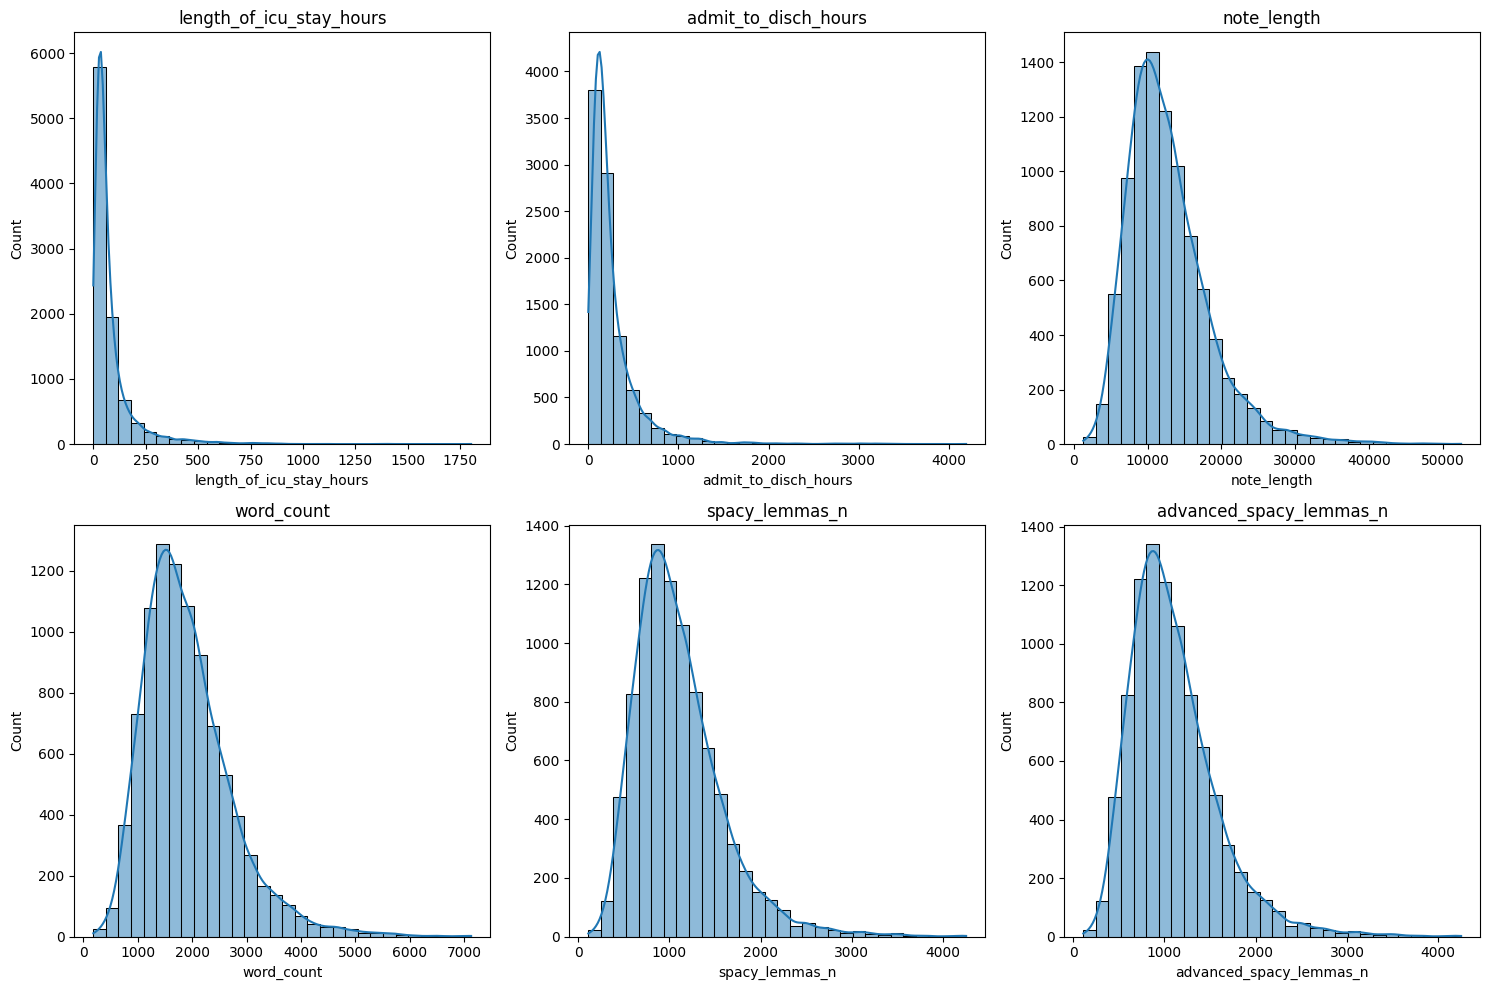

In [36]:
# Plot distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols_to_keep):
    sns.histplot(tfidf_1to1_dropped_2[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 3.2 Assigned Scalers for Retained Variables

### Scaler Selection Logic

|Condition | Best Scaling Method |
|------------| -------------------- |
|Near-normal distributions with limited outliers| StandardScaler | 
|Non-Gaussian but no extreme outliers | MinMaxScaler | 
|Strong outliers, large spread, or moderate skew | RobustScaler | 
|Highly skewed (e.g., >1.0), heavy-tailed distribution | Log Transformation | 

In [37]:
%%writefile utils/auto_assign_scalers.py

# Function to automatically classify variables into scalers based on statistical thresholds and predefined ordinal variables
def auto_assign_scalers(df, feat2scale, ordinal_vars=None):
    """
    Automatically assigns numerical variables to appropriate scalers based on statistical thresholds.
    
    Parameters:
        feat2scale: A list of numerical variables needed to be scaled.
        ordinal_vars (list): List of ordinal variables that should use MinMaxScaler.
        
    Returns:
        dict: Dictionary containing scaler assignments for each variable.
    """
    if ordinal_vars is None:
        ordinal_vars = []  # Default empty list if no ordinal variables specified
    
    scaler_groups = {"MinMaxScaler": [], "StandardScaler": [], "RobustScaler": [], "LogTransform": []}
    statistics = {'Scaler': [], 'Variable': [], 'Why': [], 'Outlier_count': [], 'Skewness': [] , 'Kurtosis': [], 'Range_val/IQR':[]}

    for col in feat2scale:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        # Compute relevant statistics
        range_val = df[col].max() - df[col].min()
        median_distance = df[col].max() - df[col].median()
        outlier_count = len(outliers)
        skewness = df[col].skew()
        kurtosis = df[col].kurt()

        # Special handling for ordinal variables (force MinMaxScaler)
        if col in ordinal_vars:
            # For discrete ordinal variables, assign highly skewed ones for RobustScaler
            if outlier_count > 10:  
                scaler_groups["RobustScaler"].append(col)
                statistics['Scaler'].append("RobustScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('ordinal variable with outlier > 10')
            # For discrete ordinal variables, remaining for MinMaxScaler
            else:
                scaler_groups["MinMaxScaler"].append(col)
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('ordinal variables')
        else:
            # For remaining continuous variables, firstly, find out normal distribution and assign them under Standard scaler
            # StandardScaler only for near-normal distributions with limited outliers
            if outlier_count < 5 and abs(skewness) < 0.5 and abs(kurtosis) < 3.0 and range_val < 5 * IQR:
                scaler_groups["StandardScaler"].append(col)
                statistics['Scaler'].append("StandardScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier < 5 & skew < 0.5 & kurtosis < 3 & range < 5 * IQR')
            # For remaining continuous variables, secondly, find out less normal distribution and assign them under MinMaxScaler
            # MinMaxScaler for non-Gaussian but no extreme outliers
            elif outlier_count < 5 and abs(skewness) < 0.5 and range_val < 10 * IQR:
                scaler_groups["MinMaxScaler"].append(col)
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier < 5 & skew < 0.5 & range < 10 * IQR')
            # For remaining continuous variables, thirdly, find out extreme skewed distribution and assign them under Log Transformation. As the degree of skewness increases, PowerTransformer generally performs better than RobustScaler.
            # Log Transform for highly skewed distributions with heavy tails
            elif abs(skewness) > 1.0 and kurtosis > 2.0:
                scaler_groups["LogTransform"].append(col)
                statistics['Scaler'].append("LogTransform")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR if IQR != 0 else np.nan)
                statistics['Why'].append('skew > 1.0 & kurtosis > 2.0') 
            # For remaining continuous variables, fourthly, find out less extreme skewed distribution and assign them under RobustScaler
            # RobustScaler for strong outliers, large spread, or moderate skew
            elif outlier_count > 5 or range_val > 10 * IQR or abs(skewness) > 0.5:
                scaler_groups["RobustScaler"].append(col)
                statistics['Scaler'].append("RobustScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier > 5 or skew > 0.5  or range > 10 * IQR')
            # For remaining continuous variables, at last, assign the remaining variables for MinMaxScaler
            else:
                scaler_groups["MinMaxScaler"].append(col)  # Default to StandardScaler
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('Default as MinMaxScaler')  

    return scaler_groups,  statistics

Overwriting utils/auto_assign_scalers.py


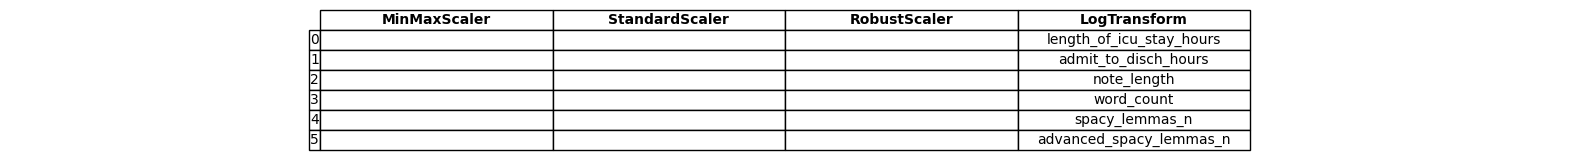

In [38]:
from utils.auto_assign_scalers import auto_assign_scalers

# Apply the customized function auto_assign_scalers() to classify 6 numerical variables
scaler_results, statistics = auto_assign_scalers(tfidf_1to1_dropped_2, cols_to_keep)

# Display the assigned scalers for each variable
scaler_df = pd.DataFrame({key: pd.Series(val) for key, val in scaler_results.items()})
statistics_df = pd.DataFrame({key: pd.Series(val) for key, val in statistics.items()})
scaler_df = scaler_df.fillna('')

# Set up figure and axis
fig, ax = plt.subplots(figsize=(20, len(scaler_df) * 0.3))  # Adjust height based on number of rows

# Hide axes
ax.axis('off')

# Create the table and add it to the plot
table = pd.plotting.table(ax, scaler_df, loc='center', cellLoc='center', colWidths=[0.15]*len(scaler_df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Bold the header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')



## 3.3 Split Data into Training and Testing Sets first, then Apply Feature Scaling

In [39]:
tfidf_1to1_dropped_2.admit_to_disch_hours.isnull().sum()

0

In [40]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_1to1_dropped_2.drop(columns=['readmit_30days']),
                                                    tfidf_1to1_dropped_2['readmit_30days'], test_size=0.3, 
                                                    random_state=42)

In [41]:
X_train.admit_to_disch_hours.isnull().sum()

0

In [42]:
X_test.admit_to_disch_hours.isnull().sum()

0

In [43]:
# Define the methods dictionary
method_dict = {
    'reference_year': lambda df, col, ref_year: df[col] - ref_year,
    'sin_cos_transform': lambda df, col: (
        df.assign(**{f"{col}_sin": np.sin(2 * np.pi * df[col] / 12),
                     f"{col}_cos": np.cos(2 * np.pi * df[col] / 12)}).drop(columns=[col])
    ),
    'MinMaxScaler': lambda: MinMaxScaler(), # Factory function to create a new instance
    'StandardScaler': lambda: StandardScaler(),
    'RobustScaler': lambda: RobustScaler(),
    'LogTransform': lambda df, col: np.log1p(df[col])  # log(1 + X) to handle zero values
}

# Define a dictionary of each variable as key and its assigned scaler as value
variable_to_method = dict(zip(statistics['Variable'], statistics['Scaler']))

# Create a dictionary to store fitted scalers
scaler_instances = {}

year_cols = []  # Default empty list if no specified
    
month_cols = []  # Default empty list if no specified

# Apply scaler methods
for col in cols_to_keep:
    method = variable_to_method[col]
    # Create a new scaler instance for each column
    scaler = method_dict[method]() if method in ['MinMaxScaler', 'StandardScaler', 'RobustScaler'] else method_dict[method]

    if col in year_cols:
        # Subtract reference year
        ref_year = X_train[col].min()
        X_train[col] = scaler(X_train, col, ref_year)
        X_test[col] = scaler(X_test, col, ref_year)
        print(f'reference year for {col} is {ref_year}')
        
    elif col in month_cols:
        # Apply sin-cos transformation and update DataFrames
        X_train = scaler(X_train, col)
        X_test = scaler(X_test, col)
    
    
    elif method == 'LogTransform':
        # Apply log transformation
        X_train[col] = scaler(X_train, col)
        if col in X_test.columns:
            X_test[col] = scaler(X_test, col)

    else:
        # Fit on train, transform on both train and test
        scaler_instances[col] = scaler.fit(X_train[[col]])
        X_train[col] = scaler_instances[col].transform(X_train[[col]])
        X_test[col] = scaler_instances[col].transform(X_test[[col]])
    

In [44]:
X_train.admit_to_disch_hours.isnull().sum()

0

In [45]:
X_test.admit_to_disch_hours.isnull().sum()

0

In [46]:
# Get the current working directory
current_dir = os.getcwd()

# # Create the full path
folder_path = os.path.join(current_dir, 'Saved')

# Save to csv file
X_train.to_csv(os.path.join(folder_path, "transformed_train_1.csv"), index=False)
X_test.to_csv(os.path.join(folder_path, "transformed_test_1.csv"), index=False)
y_train.to_csv(os.path.join(folder_path, "y_train_1.csv"), index=False)
y_test.to_csv(os.path.join(folder_path, "y_test_1.csv"), index=False)

print("Transformed datasets saved as CSV files.")

Transformed datasets saved as CSV files.


In [47]:
# Include versioning in the filename
# Create version tag based on date or manual versioning
version = "v1.0"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# Construct filename with version and timestamp
filename = f"Saved/scaler_instances_{version}_{timestamp}.joblib"

# Save metadata along with the object
metadata = {
    "scaler": scaler_instances,
    "created_by": "Sheng Miao",
    "date_saved": timestamp,
    "version": version,
    "description": "StandardScaler fitted on structured and TF-IDF combined dataset for 30-day readmission model"
}

joblib.dump(metadata, filename)

['Saved/scaler_instances_v1.0_20250702_1300.joblib']

# 4. Modeling

load saved csv files

In [6]:
X_train = pd.read_csv('Saved/transformed_train_1.csv')
X_test = pd.read_csv('Saved/transformed_test_1.csv')
y_train = pd.read_csv('Saved/y_train_1.csv')
y_test = pd.read_csv('Saved/y_test_1.csv')

## 4.1 Logistic Regression + Optuna (with regulation)

Reasons: 
- Handles high-dimensional sparse data (like TF-IDF) very well.
- Fast to train and easy to interpret (especially with L1 or L2 regularization).
- A solid baseline model.

In [20]:
null_counts = X_train.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)

Series([], dtype: int64)


In [21]:
# # Reduce verbosity and show progress bars
# optuna.logging.set_verbosity(optuna.logging.WARNING)


# # Create a stratified tuning subset: preserve all class 1, sample class 0
# positive_idx = y_train[y_train == 1].index
# negative_idx = y_train[y_train == 0].sample(n=1000, random_state=42).index  # Sample 1000 from class 0
# subset_idx = positive_idx.union(negative_idx)

# X_tune = X_train.loc[subset_idx]
# y_tune = y_train.loc[subset_idx]


# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = {}

# # Optimization for L1, L2, and ElasticNet
# def objective(trial, penalty_type):
#     C = trial.suggest_float('C', 1e-4, 1e2, log=True)
#     solver = 'saga'
#     params = {
#         'penalty': penalty_type,
#         'C': C,
#         'solver': solver,
#         'max_iter': 2000,
#         'random_state': 42
#     }
#     if penalty_type == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
#         params['l1_ratio'] = l1_ratio

#     model = LogisticRegression(**params)
#     scores = cross_val_score(model, X_tune, y_tune, cv=cv, scoring='roc_auc', n_jobs=-1)
#     return scores.mean()

# # Run Optuna optimization for each penalty type
# for penalty in ['l1', 'l2', 'elasticnet']:
#     print(f"\nOptimizing penalty: {penalty}")
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, penalty), n_trials=15, show_progress_bar=True)
#     results[penalty] = study.best_value

# # Plotting the results
# penalties = list(results.keys())
# auc_scores = list(results.values())

# # Plot
# plt.figure(figsize=(8, 4))
# bars = plt.barh(penalties, auc_scores, height=0.5, color=plt.cm.viridis(0.6))

# # Add AUC score labels to each bar
# for bar, score in zip(bars, auc_scores):
#     plt.text(score + 0.01, bar.get_y() + bar.get_height() / 2,
#              f"{score:.3f}", va='center', fontsize=10)

# # Styling
# plt.xlim(0.5, 1.0)
# plt.xlabel('ROC AUC', fontsize=12)
# plt.title('Best ROC AUC Scores by Penalty Type (Optuna)', fontsize=13)
# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.tight_layout()
# plt.show()

# # Runing took 38m 44.8s

Improvements:
- Expand and Refine Hyperparameter Search Space: 
  -  C = trial.suggest_float('C', 1e-5, 1e2, log=True), 
  -  'max_iter': 3000,
  -  'class_weight': 'balanced',
  -  l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95)
  -  n_trials=25
- Stratified Cross-Validation + SMOTE

SMOTE creates synthetic samples for the minority class to increase minority class representativeness. It must be applied within each fold, or else you'll leak information.

In [ ]:
# # Reduce verbosity and show progress bars
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Save original stdout to restore later (Save all the printed output (including progress bars and best parameters))
# original_stdout = sys.stdout
# # Redirect stdout to a file
# log_path = "Saved/logistical_regression_progress_bar_logs.txt"
# sys.stdout = open(log_path, "w")

# # Create a stratified tuning subset: preserve all class 1, sample class 0
# positive_idx = y_train[y_train == 1].index
# negative_idx = y_train[y_train == 0].sample(n=1000, random_state=42).index  # Sample 1000 from class 0
# subset_idx = positive_idx.union(negative_idx)

# X_tune = X_train.loc[subset_idx]
# y_tune = y_train.loc[subset_idx]


# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Maintains class distribution in CV folds
# results = {}

# # Optimization for L1, L2, and ElasticNet
# def objective(trial, penalty_type):
#     C = trial.suggest_float('C', 1e-5, 1e2, log=True)
#     params = {
#         'penalty': penalty_type,
#         'C': C,
#         'solver': 'saga',
#         'max_iter': 3000,
#         'random_state': 42,
#         'class_weight': 'balanced'  # NEW: Adjusts for imbalance
#     }
#     if penalty_type == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95)
#         params['l1_ratio'] = l1_ratio

#     model = LogisticRegression(**params)
#     smote = SMOTE(random_state=42) # Data Balancing or class weight tuning

#     pipe = ImbPipeline([
#         ('smote', smote),
#         ('clf', model)
#     ])

#     scores = cross_val_score(pipe, X_tune, y_tune, cv=cv, scoring='roc_auc', n_jobs=-1)
#     return scores.mean()

# # Run Optuna optimization for each penalty type
# for penalty in ['l1', 'l2', 'elasticnet']:
#     print(f"\nOptimizing penalty: {penalty}")
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, penalty), n_trials=25, show_progress_bar=True)
#     results[penalty] = study.best_value
#     print(f"Best AUC for {penalty}: {study.best_value:.4f}")
#     print(f"Best Params: {study.best_params}")


# # Plotting the results
# penalties = list(results.keys())
# auc_scores = list(results.values())

# # Plot
# plt.figure(figsize=(8, 4))
# bars = plt.barh(penalties, auc_scores, height=0.5, color=plt.cm.viridis(0.6))

# # Add AUC score labels to each bar
# for bar, score in zip(bars, auc_scores):
#     plt.text(score + 0.01, bar.get_y() + bar.get_height() / 2,
#              f"{score:.3f}", va='center', fontsize=10)

# # Styling
# plt.xlim(0.5, 1.0)
# plt.xlabel('ROC AUC', fontsize=12)
# plt.title('Best ROC AUC Scores by Penalty Type (Optuna)', fontsize=13)
# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.tight_layout()
# plt.savefig("Saved/logistical_regression_roc_auc_comparison.png", dpi=300, bbox_inches='tight')
# plt.show()

# sys.stdout.close() # Closes the log file (log_path) so the buffered content is properly written to disk. 
# sys.stdout = original_stdout # Restores standard output back to my Jupyter notebook.

# # Running took 142m 21.2s

## 4.2 Random Forest + Optuna

In [23]:
# Define Optuna Objective Function
# Optuna objective
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30), 
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20), 
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return auc_scores.mean()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_outer_trial = 15
n_inner_trial = 3

# Run the study
rf_study = optuna.create_study(direction='maximize', study_name='RandomForest Optimization')


# Run optimization with manual loop + tqdm
for _ in tqdm(range(n_outer_trial), desc='Optimizing'):
    rf_study.optimize(rf_objective, n_trials=n_inner_trial)


# Extract best score and parameters
best_score = rf_study.best_value
best_params = rf_study.best_params

# Results
print(f"\nBest AUC: {best_score:.4f}")
print("Best Parameters:", best_params)

# === Save everything ===
os.makedirs("Saved", exist_ok=True)

# 1. Save Optuna study
joblib.dump(rf_study, "Saved/random_forest_optuna_study.pkl") # Full Optuna study object (all trials)

# 2. Save best parameters to JSON
with open("Saved/random_forest_optuna_best_params.json", "w") as f:   # Best hyperparameters
    json.dump(best_params, f, indent=2)

# 3. Save trial scores to CSV
trial_scores = pd.DataFrame({
    "trial": [t.number for t in rf_study.trials],
    "auc_score": [t.value for t in rf_study.trials]
})
trial_scores.to_csv("Saved/random_forest_optuna_trial_scores.csv", index=False)  # Trial number and AUC for each trial


[I 2025-07-02 15:01:15,823] A new study created in memory with name: RandomForest Optimization
Optimizing:   0%|          | 0/15 [00:00<?, ?it/s][I 2025-07-02 15:01:34,643] Trial 0 finished with value: 0.5389351000665573 and parameters: {'n_estimators': 229, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.5389351000665573.
[I 2025-07-02 15:01:40,696] Trial 1 finished with value: 0.591729215892081 and parameters: {'n_estimators': 289, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.591729215892081.
[I 2025-07-02 15:01:46,586] Trial 2 finished with value: 0.5887013662973678 and parameters: {'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.591729215892081.
Optimizing:   7%|▋         | 1/15 [00:30<07:


Best AUC: 0.6117
Best Parameters: {'n_estimators': 254, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True}


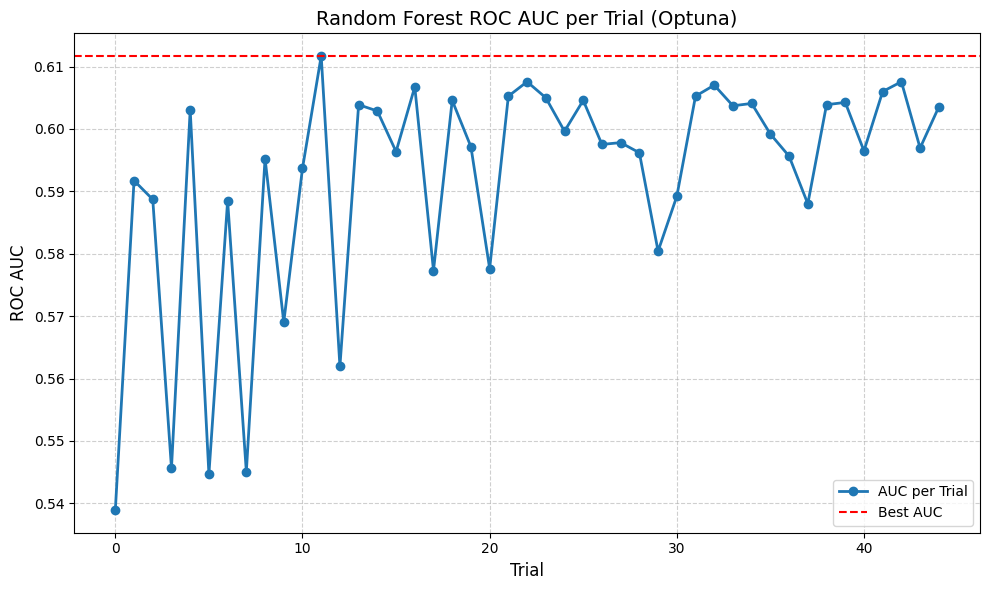

In [27]:
# 4. Plotting and save figure
plt.figure(figsize=(10, 6))
plt.plot(trial_scores["trial"], trial_scores["auc_score"], marker='o', linewidth=2, label='AUC per Trial')
plt.axhline(best_score, color='r', linestyle='--', label='Best AUC')
plt.title('Random Forest ROC AUC per Trial (Optuna)', fontsize=14)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("Saved/random_forest_optuna.png", dpi=300, bbox_inches='tight')
plt.show()


## 4.3 Gradient Boosting XGBoost + Optuna 

In [28]:
# Define Optuna objective
def xgb_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        # 'tree_method': 'hist',  # use 'gpu_hist' if using GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores.mean()

In [30]:
# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create study and optimize with progress bar
XGBoost_study = optuna.create_study(direction='maximize', study_name='XGBoost Optimization')

XGBoost_study.optimize(xgb_objective, n_trials=30, show_progress_bar=True)

# Report best result
print(f"\n Best ROC AUC: {XGBoost_study.best_value:.4f}")
print("Best Parameters:")
print(json.dumps(XGBoost_study.best_params, indent=2))


[I 2025-07-02 15:30:17,780] A new study created in memory with name: XGBoost Optimization
Best trial: 0. Best value: 0.638306:   3%|▎         | 1/30 [01:43<50:12, 103.88s/it]

[I 2025-07-02 15:32:01,657] Trial 0 finished with value: 0.6383055852708042 and parameters: {'n_estimators': 694, 'max_depth': 4, 'learning_rate': 0.00480141372954935, 'subsample': 0.5528907654872071, 'colsample_bytree': 0.6729100378538058, 'reg_alpha': 0.002446665607533447, 'reg_lambda': 1.3926622154911489e-05, 'min_child_weight': 9}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:   7%|▋         | 2/30 [03:32<49:51, 106.85s/it]

[I 2025-07-02 15:33:50,591] Trial 1 finished with value: 0.5225216414874173 and parameters: {'n_estimators': 799, 'max_depth': 3, 'learning_rate': 0.1105816072027165, 'subsample': 0.8719977686141862, 'colsample_bytree': 0.6630922875107281, 'reg_alpha': 1.4964925715013599e-05, 'reg_lambda': 1.16490333392535e-05, 'min_child_weight': 8}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  10%|█         | 3/30 [06:53<1:07:23, 149.76s/it]

[I 2025-07-02 15:37:11,407] Trial 2 finished with value: 0.5009137049960424 and parameters: {'n_estimators': 988, 'max_depth': 7, 'learning_rate': 0.013629929783744436, 'subsample': 0.8028062692361493, 'colsample_bytree': 0.8490641631741329, 'reg_alpha': 6.702753123476778e-05, 'reg_lambda': 0.015861175379391454, 'min_child_weight': 4}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  13%|█▎        | 4/30 [08:12<52:44, 121.71s/it]  

[I 2025-07-02 15:38:30,124] Trial 3 finished with value: 0.5671521654728092 and parameters: {'n_estimators': 401, 'max_depth': 8, 'learning_rate': 0.0018081590570184292, 'subsample': 0.841146377193845, 'colsample_bytree': 0.5669524090162631, 'reg_alpha': 0.0012724000817531263, 'reg_lambda': 0.0004332985437240852, 'min_child_weight': 5}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  17%|█▋        | 5/30 [09:48<46:54, 112.59s/it]

[I 2025-07-02 15:40:06,543] Trial 4 finished with value: 0.4698795234296497 and parameters: {'n_estimators': 733, 'max_depth': 9, 'learning_rate': 0.0811013293853846, 'subsample': 0.6704233648645206, 'colsample_bytree': 0.7270803161789223, 'reg_alpha': 7.448809896491226e-05, 'reg_lambda': 0.026573036524987163, 'min_child_weight': 2}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  20%|██        | 6/30 [11:49<46:05, 115.21s/it]

[I 2025-07-02 15:42:06,841] Trial 5 finished with value: 0.6108160675230516 and parameters: {'n_estimators': 743, 'max_depth': 7, 'learning_rate': 0.0016717966391834214, 'subsample': 0.536872366833206, 'colsample_bytree': 0.5165391952832833, 'reg_alpha': 0.6291354500195574, 'reg_lambda': 0.014284448870396736, 'min_child_weight': 5}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  23%|██▎       | 7/30 [13:44<44:15, 115.44s/it]

[I 2025-07-02 15:44:02,751] Trial 6 finished with value: 0.6240384806062546 and parameters: {'n_estimators': 703, 'max_depth': 7, 'learning_rate': 0.0011820059412350036, 'subsample': 0.6752480729416617, 'colsample_bytree': 0.6294063749932637, 'reg_alpha': 0.05441950389978098, 'reg_lambda': 3.432109331063662, 'min_child_weight': 6}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  27%|██▋       | 8/30 [16:00<44:43, 121.97s/it]

[I 2025-07-02 15:46:18,711] Trial 7 finished with value: 0.5582526643655958 and parameters: {'n_estimators': 835, 'max_depth': 4, 'learning_rate': 0.0015404143291527104, 'subsample': 0.8980722113698952, 'colsample_bytree': 0.6954858604334766, 'reg_alpha': 0.3165488815801618, 'reg_lambda': 1.4416447509230267e-05, 'min_child_weight': 5}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  30%|███       | 9/30 [16:26<32:09, 91.87s/it] 

[I 2025-07-02 15:46:44,391] Trial 8 finished with value: 0.5957717092772349 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.005918691365417209, 'subsample': 0.8034778776039109, 'colsample_bytree': 0.9448237348809418, 'reg_alpha': 1.7577310011336065e-05, 'reg_lambda': 0.00022375487056271832, 'min_child_weight': 8}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  33%|███▎      | 10/30 [18:17<32:35, 97.76s/it]

[I 2025-07-02 15:48:35,329] Trial 9 finished with value: 0.501089994369357 and parameters: {'n_estimators': 674, 'max_depth': 9, 'learning_rate': 0.017155156829818614, 'subsample': 0.8551821092967723, 'colsample_bytree': 0.8127751359857006, 'reg_alpha': 0.0017802924506823245, 'reg_lambda': 0.012577509947565898, 'min_child_weight': 6}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  37%|███▋      | 11/30 [18:59<25:30, 80.54s/it]

[I 2025-07-02 15:49:16,815] Trial 10 finished with value: 0.6104835793658289 and parameters: {'n_estimators': 373, 'max_depth': 12, 'learning_rate': 0.27944403843185306, 'subsample': 0.5034706711826142, 'colsample_bytree': 0.9660130813706878, 'reg_alpha': 7.699310030566606, 'reg_lambda': 0.9874291119005236, 'min_child_weight': 9}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 0. Best value: 0.638306:  40%|████      | 12/30 [20:13<23:38, 78.80s/it]

[I 2025-07-02 15:50:31,625] Trial 11 finished with value: 0.6281804460911695 and parameters: {'n_estimators': 555, 'max_depth': 5, 'learning_rate': 0.004838321156498221, 'subsample': 0.6450073687523593, 'colsample_bytree': 0.6092216892454451, 'reg_alpha': 0.01948774498098988, 'reg_lambda': 8.347955289271184, 'min_child_weight': 7}. Best is trial 0 with value: 0.6383055852708042.


Best trial: 12. Best value: 0.639279:  43%|████▎     | 13/30 [21:12<20:36, 72.73s/it]

[I 2025-07-02 15:51:30,412] Trial 12 finished with value: 0.6392787833064004 and parameters: {'n_estimators': 520, 'max_depth': 5, 'learning_rate': 0.005414773249596505, 'subsample': 0.6002008074343136, 'colsample_bytree': 0.6087815751234045, 'reg_alpha': 0.0072077076713604835, 'reg_lambda': 0.33162868366240345, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  47%|████▋     | 14/30 [22:04<17:41, 66.33s/it]

[I 2025-07-02 15:52:21,935] Trial 13 finished with value: 0.6358474004832053 and parameters: {'n_estimators': 460, 'max_depth': 5, 'learning_rate': 0.006756896764699793, 'subsample': 0.5935815274736319, 'colsample_bytree': 0.7787061763355808, 'reg_alpha': 0.0007898030486589338, 'reg_lambda': 0.2734480612061181, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  50%|█████     | 15/30 [22:35<13:55, 55.70s/it]

[I 2025-07-02 15:52:53,022] Trial 14 finished with value: 0.5281788169389364 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.036132009536904854, 'subsample': 0.9666206398422, 'colsample_bytree': 0.5104122742892676, 'reg_alpha': 0.005352079919006727, 'reg_lambda': 0.22925314456519574, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  53%|█████▎    | 16/30 [23:46<14:04, 60.30s/it]

[I 2025-07-02 15:54:03,980] Trial 15 finished with value: 0.6314522025039887 and parameters: {'n_estimators': 563, 'max_depth': 5, 'learning_rate': 0.0037357272164592237, 'subsample': 0.5903715741044122, 'colsample_bytree': 0.5793659560058565, 'reg_alpha': 0.00029080341524421023, 'reg_lambda': 0.000736971739226249, 'min_child_weight': 9}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  57%|█████▋    | 17/30 [26:44<20:45, 95.80s/it]

[I 2025-07-02 15:57:02,357] Trial 16 finished with value: 0.5209121084878708 and parameters: {'n_estimators': 920, 'max_depth': 5, 'learning_rate': 0.009585726744695893, 'subsample': 0.7364091822155149, 'colsample_bytree': 0.6846880340510955, 'reg_alpha': 0.04537244073238692, 'reg_lambda': 0.13818623010405956, 'min_child_weight': 1}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  60%|██████    | 18/30 [27:52<17:28, 87.37s/it]

[I 2025-07-02 15:58:10,093] Trial 17 finished with value: 0.6010077366731076 and parameters: {'n_estimators': 617, 'max_depth': 4, 'learning_rate': 0.03169855569722563, 'subsample': 0.5830702312164939, 'colsample_bytree': 0.7464478687804614, 'reg_alpha': 0.009134527733457076, 'reg_lambda': 8.27467895467775e-05, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  63%|██████▎   | 19/30 [28:58<14:51, 81.04s/it]

[I 2025-07-02 15:59:16,402] Trial 18 finished with value: 0.6062122099224279 and parameters: {'n_estimators': 448, 'max_depth': 12, 'learning_rate': 0.003930088062741026, 'subsample': 0.71388060458489, 'colsample_bytree': 0.8854092482457296, 'reg_alpha': 0.23917360897892082, 'reg_lambda': 0.002479904733730448, 'min_child_weight': 8}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  67%|██████▋   | 20/30 [29:46<11:49, 71.00s/it]

[I 2025-07-02 16:00:03,986] Trial 19 finished with value: 0.5591283390298746 and parameters: {'n_estimators': 301, 'max_depth': 6, 'learning_rate': 0.002735022784301753, 'subsample': 0.5423555659690548, 'colsample_bytree': 0.6432571111502924, 'reg_alpha': 0.0002643581071796241, 'reg_lambda': 0.002740397396498766, 'min_child_weight': 3}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  70%|███████   | 21/30 [30:51<10:23, 69.31s/it]

[I 2025-07-02 16:01:09,351] Trial 20 finished with value: 0.5879330539855897 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.023541084040334455, 'subsample': 0.6335953060812705, 'colsample_bytree': 0.5668629671355585, 'reg_alpha': 0.0033003205240399723, 'reg_lambda': 0.07343704252827628, 'min_child_weight': 9}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  73%|███████▎  | 22/30 [32:00<09:12, 69.06s/it]

[I 2025-07-02 16:02:17,833] Trial 21 finished with value: 0.631829287940881 and parameters: {'n_estimators': 616, 'max_depth': 6, 'learning_rate': 0.008256312556317568, 'subsample': 0.5918311086772664, 'colsample_bytree': 0.7831820883900824, 'reg_alpha': 0.00043573428659123643, 'reg_lambda': 0.6842643545451472, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  77%|███████▋  | 23/30 [32:55<07:33, 64.85s/it]

[I 2025-07-02 16:03:12,851] Trial 22 finished with value: 0.6305762273312925 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.008848192219511676, 'subsample': 0.510484541426694, 'colsample_bytree': 0.7118475739397673, 'reg_alpha': 0.0008047123488345152, 'reg_lambda': 0.7273824621570619, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  80%|████████  | 24/30 [33:45<06:02, 60.45s/it]

[I 2025-07-02 16:04:03,047] Trial 23 finished with value: 0.6179132854130712 and parameters: {'n_estimators': 341, 'max_depth': 6, 'learning_rate': 0.002461036493095765, 'subsample': 0.6165386225256184, 'colsample_bytree': 0.7805086323958468, 'reg_alpha': 0.021137893212638568, 'reg_lambda': 0.0635384834874929, 'min_child_weight': 7}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  83%|████████▎ | 25/30 [35:04<05:30, 66.17s/it]

[I 2025-07-02 16:05:22,556] Trial 24 finished with value: 0.6208801043414038 and parameters: {'n_estimators': 630, 'max_depth': 5, 'learning_rate': 0.006021003752834104, 'subsample': 0.5755347703812687, 'colsample_bytree': 0.8521913826014529, 'reg_alpha': 0.00012121435673656474, 'reg_lambda': 0.2355804149074085, 'min_child_weight': 9}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  87%|████████▋ | 26/30 [35:39<03:47, 56.77s/it]

[I 2025-07-02 16:05:57,387] Trial 25 finished with value: 0.6282327574371716 and parameters: {'n_estimators': 251, 'max_depth': 4, 'learning_rate': 0.011237621290551671, 'subsample': 0.544334629326376, 'colsample_bytree': 0.6081267827243366, 'reg_alpha': 0.003351384908928815, 'reg_lambda': 2.513239972640518, 'min_child_weight': 7}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  90%|█████████ | 27/30 [36:37<02:50, 56.97s/it]

[I 2025-07-02 16:06:54,848] Trial 26 finished with value: 0.6303768277928734 and parameters: {'n_estimators': 433, 'max_depth': 6, 'learning_rate': 0.0028387166518288654, 'subsample': 0.6988136375193927, 'colsample_bytree': 0.7752277582003408, 'reg_alpha': 0.08063119731495433, 'reg_lambda': 4.137079882963571e-05, 'min_child_weight': 10}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  93%|█████████▎| 28/30 [37:45<02:00, 60.31s/it]

[I 2025-07-02 16:08:02,953] Trial 27 finished with value: 0.6129606610989932 and parameters: {'n_estimators': 511, 'max_depth': 10, 'learning_rate': 0.006785134562721628, 'subsample': 0.6216397716990428, 'colsample_bytree': 0.6722026625445997, 'reg_alpha': 0.012486207240215255, 'reg_lambda': 0.0024889940009160923, 'min_child_weight': 8}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279:  97%|█████████▋| 29/30 [39:34<01:15, 75.09s/it]

[I 2025-07-02 16:09:52,518] Trial 28 finished with value: 0.6318683936961693 and parameters: {'n_estimators': 838, 'max_depth': 4, 'learning_rate': 0.0010283794640503984, 'subsample': 0.6676119114616877, 'colsample_bytree': 0.7313088841511302, 'reg_alpha': 0.0007265406212772931, 'reg_lambda': 0.3388519348731367, 'min_child_weight': 9}. Best is trial 12 with value: 0.6392787833064004.


Best trial: 12. Best value: 0.639279: 100%|██████████| 30/30 [41:07<00:00, 82.26s/it]

[I 2025-07-02 16:11:25,451] Trial 29 finished with value: 0.5203232347860978 and parameters: {'n_estimators': 766, 'max_depth': 3, 'learning_rate': 0.05619815138888329, 'subsample': 0.7765546178110119, 'colsample_bytree': 0.6556982681014527, 'reg_alpha': 1.6053220510878373e-05, 'reg_lambda': 0.053317827663839204, 'min_child_weight': 8}. Best is trial 12 with value: 0.6392787833064004.

 Best ROC AUC: 0.6393
Best Parameters:
{
  "n_estimators": 520,
  "max_depth": 5,
  "learning_rate": 0.005414773249596505,
  "subsample": 0.6002008074343136,
  "colsample_bytree": 0.6087815751234045,
  "reg_alpha": 0.0072077076713604835,
  "reg_lambda": 0.33162868366240345,
  "min_child_weight": 10
}


In [31]:
# Save study object
joblib.dump(XGBoost_study, "Saved/XGBoost_optuna_study.pkl")

# Save best params
with open("Saved/XGBoost_optuna_best_params.json", "w") as f:
    json.dump(XGBoost_study.best_params, f, indent=2)

# Save trial scores
trial_df = pd.DataFrame({
    'trial': [t.number for t in XGBoost_study.trials],
    'auc_score': [t.value for t in XGBoost_study.trials]
})
trial_df.to_csv("Saved/XGBoost_optuna_trial_scores.csv", index=False)


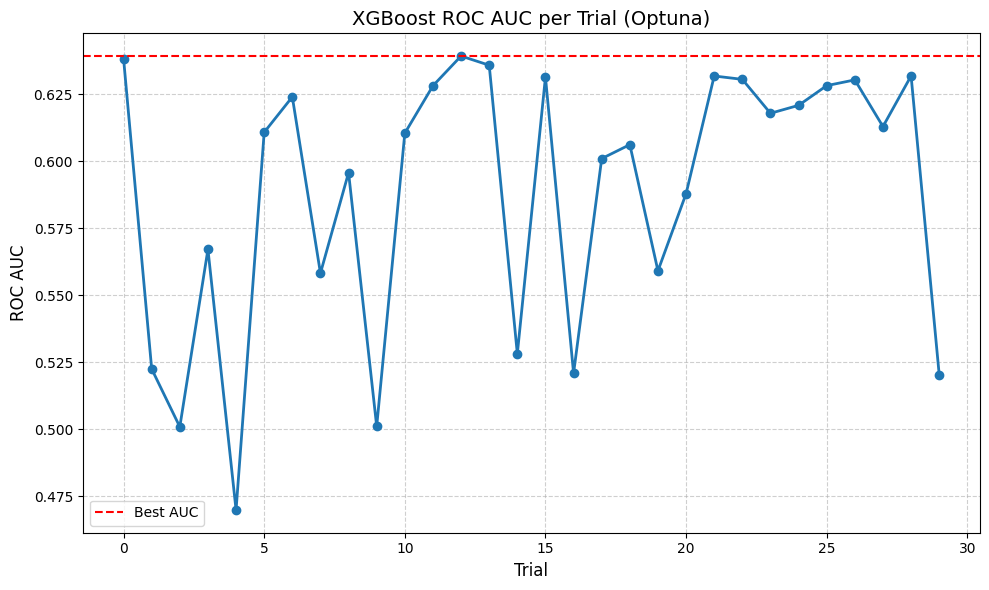

In [32]:
# Plot and save performance
plt.figure(figsize=(10, 6))
plt.plot(trial_df['trial'], trial_df['auc_score'], marker='o', linewidth=2)
plt.axhline(XGBoost_study.best_value, color='r', linestyle='--', label='Best AUC')
plt.title("XGBoost ROC AUC per Trial (Optuna)", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("Saved/XGBoost_auc_trials.png", dpi=300, bbox_inches='tight')
plt.show()

## 4.4 Gradient Boosting LightGBM + Optuna 

In [33]:
# Objective function for Optuna
def lgb_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

In [ ]:
# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run Optuna study with progress bar
lgb_study = optuna.create_study(direction='maximize', study_name='LightGBM Optimization')
lgb_study.optimize(lgb_objective, n_trials=30, show_progress_bar=True)

# Report best score and parameters
print(f"\n Best ROC AUC: {lgb_study.best_value:.4f}")
print("Best Parameters:")
for k, v in lgb_study.best_params.items():
    print(f"{k}: {v}")

[I 2025-07-02 16:23:35,434] A new study created in memory with name: LightGBM Optimization
Best trial: 0. Best value: 0.507662:   3%|▎         | 1/30 [00:36<17:29, 36.19s/it]

[I 2025-07-02 16:24:11,621] Trial 0 finished with value: 0.5076618518506315 and parameters: {'learning_rate': 0.07260975242882176, 'num_leaves': 192, 'max_depth': 5, 'min_data_in_leaf': 18, 'feature_fraction': 0.9404270138706352, 'bagging_fraction': 0.9608632879597361, 'bagging_freq': 8, 'lambda_l1': 0.0012068374051895463, 'lambda_l2': 0.00016793476145128932}. Best is trial 0 with value: 0.5076618518506315.


Best trial: 1. Best value: 0.536834:   7%|▋         | 2/30 [01:02<14:11, 30.40s/it]

[I 2025-07-02 16:24:37,962] Trial 1 finished with value: 0.5368335943637923 and parameters: {'learning_rate': 0.1700296085576345, 'num_leaves': 228, 'max_depth': 13, 'min_data_in_leaf': 88, 'feature_fraction': 0.9152733475308158, 'bagging_fraction': 0.7030267682221129, 'bagging_freq': 7, 'lambda_l1': 1.2166556197426946e-06, 'lambda_l2': 6.8785064122369635}. Best is trial 1 with value: 0.5368335943637923.


Best trial: 2. Best value: 0.56893:  10%|█         | 3/30 [01:25<12:06, 26.91s/it] 

[I 2025-07-02 16:25:00,716] Trial 2 finished with value: 0.5689297894573959 and parameters: {'learning_rate': 0.0076421623879435975, 'num_leaves': 95, 'max_depth': 5, 'min_data_in_leaf': 32, 'feature_fraction': 0.6927212010379722, 'bagging_fraction': 0.7158928415165395, 'bagging_freq': 1, 'lambda_l1': 0.0343527018973533, 'lambda_l2': 2.653021889610061e-06}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  13%|█▎        | 4/30 [01:54<12:01, 27.76s/it]

[I 2025-07-02 16:25:29,784] Trial 3 finished with value: 0.4939912358016637 and parameters: {'learning_rate': 0.006388692682154156, 'num_leaves': 239, 'max_depth': 12, 'min_data_in_leaf': 33, 'feature_fraction': 0.7337838876099452, 'bagging_fraction': 0.8086258639090043, 'bagging_freq': 7, 'lambda_l1': 2.357538671125284e-07, 'lambda_l2': 0.41775762766524116}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  17%|█▋        | 5/30 [02:15<10:37, 25.52s/it]

[I 2025-07-02 16:25:51,322] Trial 4 finished with value: 0.5231466677247003 and parameters: {'learning_rate': 0.0027083537050754673, 'num_leaves': 236, 'max_depth': 6, 'min_data_in_leaf': 87, 'feature_fraction': 0.7363242092858782, 'bagging_fraction': 0.9333278986219422, 'bagging_freq': 10, 'lambda_l1': 1.6666095031340264e-08, 'lambda_l2': 9.236443082663512e-05}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  20%|██        | 6/30 [02:40<10:05, 25.22s/it]

[I 2025-07-02 16:26:15,979] Trial 5 finished with value: 0.5439481380132347 and parameters: {'learning_rate': 0.012011222811404255, 'num_leaves': 95, 'max_depth': 13, 'min_data_in_leaf': 70, 'feature_fraction': 0.9959597590860394, 'bagging_fraction': 0.6669632820953051, 'bagging_freq': 7, 'lambda_l1': 0.00024182917993724587, 'lambda_l2': 2.42351851261837e-07}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  23%|██▎       | 7/30 [02:59<08:49, 23.01s/it]

[I 2025-07-02 16:26:34,437] Trial 6 finished with value: 0.5496910643806793 and parameters: {'learning_rate': 0.002792209850268427, 'num_leaves': 230, 'max_depth': 7, 'min_data_in_leaf': 24, 'feature_fraction': 0.6950781716138802, 'bagging_fraction': 0.5837508255377379, 'bagging_freq': 2, 'lambda_l1': 1.808898572303299e-07, 'lambda_l2': 0.004281762345598644}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  27%|██▋       | 8/30 [03:23<08:34, 23.39s/it]

[I 2025-07-02 16:26:58,630] Trial 7 finished with value: 0.5067657479529427 and parameters: {'learning_rate': 0.12802945338245866, 'num_leaves': 69, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.502779175375538, 'bagging_fraction': 0.9002189538418381, 'bagging_freq': 1, 'lambda_l1': 6.265031608190614e-08, 'lambda_l2': 0.006973084280194755}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 2. Best value: 0.56893:  30%|███       | 9/30 [03:46<08:12, 23.43s/it]

[I 2025-07-02 16:27:22,142] Trial 8 finished with value: 0.5271027229906695 and parameters: {'learning_rate': 0.05287193349827776, 'num_leaves': 29, 'max_depth': 8, 'min_data_in_leaf': 37, 'feature_fraction': 0.6275981658889371, 'bagging_fraction': 0.7328942474520039, 'bagging_freq': 7, 'lambda_l1': 0.00658863410439194, 'lambda_l2': 0.0013648717112826312}. Best is trial 2 with value: 0.5689297894573959.


Best trial: 9. Best value: 0.598596:  33%|███▎      | 10/30 [03:58<06:34, 19.74s/it]

[I 2025-07-02 16:27:33,628] Trial 9 finished with value: 0.5985957211140326 and parameters: {'learning_rate': 0.004982099006148298, 'num_leaves': 189, 'max_depth': 3, 'min_data_in_leaf': 26, 'feature_fraction': 0.5233950953930708, 'bagging_fraction': 0.5099040387370675, 'bagging_freq': 10, 'lambda_l1': 0.01181722964628491, 'lambda_l2': 0.00026593101117116156}. Best is trial 9 with value: 0.5985957211140326.


Best trial: 10. Best value: 0.598939:  37%|███▋      | 11/30 [04:10<05:33, 17.58s/it]

[I 2025-07-02 16:27:46,311] Trial 10 finished with value: 0.5989388056251759 and parameters: {'learning_rate': 0.0012978066852119509, 'num_leaves': 173, 'max_depth': 3, 'min_data_in_leaf': 57, 'feature_fraction': 0.5061423311249903, 'bagging_fraction': 0.5032700526605071, 'bagging_freq': 10, 'lambda_l1': 3.466055376174343, 'lambda_l2': 2.3459198508256137e-08}. Best is trial 10 with value: 0.5989388056251759.


Best trial: 11. Best value: 0.631905:  40%|████      | 12/30 [04:21<04:36, 15.38s/it]

[I 2025-07-02 16:27:56,648] Trial 11 finished with value: 0.6319051930112176 and parameters: {'learning_rate': 0.0013691315858490763, 'num_leaves': 166, 'max_depth': 3, 'min_data_in_leaf': 59, 'feature_fraction': 0.5008545852260579, 'bagging_fraction': 0.5267928393868748, 'bagging_freq': 10, 'lambda_l1': 9.411205419185405, 'lambda_l2': 2.8406627808123057e-08}. Best is trial 11 with value: 0.6319051930112176.


Best trial: 12. Best value: 0.642253:  43%|████▎     | 13/30 [04:32<03:59, 14.07s/it]

[I 2025-07-02 16:28:07,721] Trial 12 finished with value: 0.6422528365553937 and parameters: {'learning_rate': 0.0011234655416568406, 'num_leaves': 146, 'max_depth': 3, 'min_data_in_leaf': 56, 'feature_fraction': 0.5982954466740837, 'bagging_fraction': 0.503933587769379, 'bagging_freq': 4, 'lambda_l1': 9.593111462986858, 'lambda_l2': 1.3042569691326063e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  47%|████▋     | 14/30 [04:49<03:59, 15.00s/it]

[I 2025-07-02 16:28:24,862] Trial 13 finished with value: 0.548306662524837 and parameters: {'learning_rate': 0.001275725448166862, 'num_leaves': 144, 'max_depth': 10, 'min_data_in_leaf': 54, 'feature_fraction': 0.6004951627942208, 'bagging_fraction': 0.6055837597388227, 'bagging_freq': 3, 'lambda_l1': 1.2341751560462013, 'lambda_l2': 1.3490356638781456e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  50%|█████     | 15/30 [05:03<03:39, 14.66s/it]

[I 2025-07-02 16:28:38,744] Trial 14 finished with value: 0.575417248310624 and parameters: {'learning_rate': 0.028254425338089785, 'num_leaves': 151, 'max_depth': 3, 'min_data_in_leaf': 53, 'feature_fraction': 0.5973954409391592, 'bagging_fraction': 0.580634799637737, 'bagging_freq': 4, 'lambda_l1': 0.26959789369812204, 'lambda_l2': 2.272242687608507e-06}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  53%|█████▎    | 16/30 [05:23<03:50, 16.45s/it]

[I 2025-07-02 16:28:59,363] Trial 15 finished with value: 0.5852776380489907 and parameters: {'learning_rate': 0.001062014284812403, 'num_leaves': 111, 'max_depth': 10, 'min_data_in_leaf': 68, 'feature_fraction': 0.8285003419056568, 'bagging_fraction': 0.8113714224959203, 'bagging_freq': 5, 'lambda_l1': 9.235742095813144, 'lambda_l2': 6.273632017915641e-07}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  57%|█████▋    | 17/30 [05:42<03:43, 17.18s/it]

[I 2025-07-02 16:29:18,243] Trial 16 finished with value: 0.563814649580948 and parameters: {'learning_rate': 0.002744469776178116, 'num_leaves': 124, 'max_depth': 5, 'min_data_in_leaf': 44, 'feature_fraction': 0.5733593547815569, 'bagging_fraction': 0.6342859656591672, 'bagging_freq': 5, 'lambda_l1': 5.957075104684367e-05, 'lambda_l2': 9.593185337437031e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  60%|██████    | 18/30 [06:00<03:26, 17.21s/it]

[I 2025-07-02 16:29:35,497] Trial 17 finished with value: 0.5265468747063561 and parameters: {'learning_rate': 0.019618532170896034, 'num_leaves': 176, 'max_depth': 4, 'min_data_in_leaf': 73, 'feature_fraction': 0.8234712608875898, 'bagging_fraction': 0.5537530664608787, 'bagging_freq': 3, 'lambda_l1': 0.1576667111478171, 'lambda_l2': 1.4412650268259744e-05}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  63%|██████▎   | 19/30 [06:15<03:03, 16.68s/it]

[I 2025-07-02 16:29:50,959] Trial 18 finished with value: 0.5865432628087366 and parameters: {'learning_rate': 0.0019637344098150686, 'num_leaves': 155, 'max_depth': 7, 'min_data_in_leaf': 98, 'feature_fraction': 0.6525588533438343, 'bagging_fraction': 0.5410847571483233, 'bagging_freq': 9, 'lambda_l1': 0.7574684103064085, 'lambda_l2': 8.850686611810694e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  67%|██████▋   | 20/30 [06:32<02:46, 16.68s/it]

[I 2025-07-02 16:30:07,625] Trial 19 finished with value: 0.5700389088231224 and parameters: {'learning_rate': 0.003915257457599025, 'num_leaves': 208, 'max_depth': 8, 'min_data_in_leaf': 62, 'feature_fraction': 0.549544592489583, 'bagging_fraction': 0.6220948070898573, 'bagging_freq': 6, 'lambda_l1': 7.842035425337874e-06, 'lambda_l2': 1.3024510642199477e-05}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  70%|███████   | 21/30 [06:48<02:28, 16.50s/it]

[I 2025-07-02 16:30:23,722] Trial 20 finished with value: 0.5835976915034891 and parameters: {'learning_rate': 0.00866211885947446, 'num_leaves': 60, 'max_depth': 4, 'min_data_in_leaf': 43, 'feature_fraction': 0.7968216548764373, 'bagging_fraction': 0.7935836937874979, 'bagging_freq': 4, 'lambda_l1': 0.08020297608502015, 'lambda_l2': 1.4926948104417333e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  73%|███████▎  | 22/30 [07:03<02:09, 16.21s/it]

[I 2025-07-02 16:30:39,257] Trial 21 finished with value: 0.6058011197462281 and parameters: {'learning_rate': 0.0016285580738103806, 'num_leaves': 170, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 0.5382351907930156, 'bagging_fraction': 0.5099956772224561, 'bagging_freq': 9, 'lambda_l1': 9.783657184313713, 'lambda_l2': 2.038250645871468e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  77%|███████▋  | 23/30 [07:14<01:42, 14.64s/it]

[I 2025-07-02 16:30:50,241] Trial 22 finished with value: 0.6038484854558808 and parameters: {'learning_rate': 0.0017618830887569368, 'num_leaves': 130, 'max_depth': 4, 'min_data_in_leaf': 78, 'feature_fraction': 0.5511279102294578, 'bagging_fraction': 0.5404523722951022, 'bagging_freq': 9, 'lambda_l1': 9.821961001905311, 'lambda_l2': 7.210941671350944e-07}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  80%|████████  | 24/30 [07:27<01:24, 14.05s/it]

[I 2025-07-02 16:31:02,913] Trial 23 finished with value: 0.5719793465903613 and parameters: {'learning_rate': 0.0017814281284842847, 'num_leaves': 165, 'max_depth': 3, 'min_data_in_leaf': 48, 'feature_fraction': 0.6597032827800257, 'bagging_fraction': 0.5053625826062641, 'bagging_freq': 9, 'lambda_l1': 1.176259411627971, 'lambda_l2': 8.781681923179283e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  83%|████████▎ | 25/30 [07:45<01:16, 15.32s/it]

[I 2025-07-02 16:31:21,196] Trial 24 finished with value: 0.5386740200313724 and parameters: {'learning_rate': 0.003908013448862637, 'num_leaves': 203, 'max_depth': 6, 'min_data_in_leaf': 60, 'feature_fraction': 0.565623857316107, 'bagging_fraction': 0.6519761769682566, 'bagging_freq': 8, 'lambda_l1': 0.5119146688026392, 'lambda_l2': 1.0779162528255134e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  87%|████████▋ | 26/30 [07:59<00:59, 14.98s/it]

[I 2025-07-02 16:31:35,392] Trial 25 finished with value: 0.5538220826642826 and parameters: {'learning_rate': 0.289907382465321, 'num_leaves': 132, 'max_depth': 4, 'min_data_in_leaf': 64, 'feature_fraction': 0.6272766738230907, 'bagging_fraction': 0.5715430836586638, 'bagging_freq': 6, 'lambda_l1': 2.5746802358139402, 'lambda_l2': 7.0281374888897905e-06}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  90%|█████████ | 27/30 [08:14<00:44, 14.96s/it]

[I 2025-07-02 16:31:50,285] Trial 26 finished with value: 0.5795396090534979 and parameters: {'learning_rate': 0.0011243081307007472, 'num_leaves': 212, 'max_depth': 6, 'min_data_in_leaf': 81, 'feature_fraction': 0.535447677902646, 'bagging_fraction': 0.5387035536087701, 'bagging_freq': 8, 'lambda_l1': 0.0031926747345385055, 'lambda_l2': 3.36220415533665e-07}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  93%|█████████▎| 28/30 [08:30<00:30, 15.17s/it]

[I 2025-07-02 16:32:05,948] Trial 27 finished with value: 0.5286294186330596 and parameters: {'learning_rate': 0.002011818241777965, 'num_leaves': 111, 'max_depth': 5, 'min_data_in_leaf': 49, 'feature_fraction': 0.5934525614354242, 'bagging_fraction': 0.6742773406964879, 'bagging_freq': 4, 'lambda_l1': 0.03071116181303832, 'lambda_l2': 0.04997318991215606}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253:  97%|█████████▋| 29/30 [08:44<00:14, 14.69s/it]

[I 2025-07-02 16:32:19,522] Trial 28 finished with value: 0.5743411627521862 and parameters: {'learning_rate': 0.0035684607144600804, 'num_leaves': 185, 'max_depth': 3, 'min_data_in_leaf': 64, 'feature_fraction': 0.502011188627899, 'bagging_fraction': 0.7651403464565059, 'bagging_freq': 9, 'lambda_l1': 5.481892954205671, 'lambda_l2': 5.674093868272611e-08}. Best is trial 12 with value: 0.6422528365553937.


Best trial: 12. Best value: 0.642253: 100%|██████████| 30/30 [09:03<00:00, 18.12s/it]

[I 2025-07-02 16:32:38,995] Trial 29 finished with value: 0.5524769177501444 and parameters: {'learning_rate': 0.04379157561256663, 'num_leaves': 156, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.6268198451060063, 'bagging_fraction': 0.6136032634758886, 'bagging_freq': 10, 'lambda_l1': 0.0005290196683184618, 'lambda_l2': 5.655585977540439e-05}. Best is trial 12 with value: 0.6422528365553937.

 Best ROC AUC: 0.6423
Best Parameters:
learning_rate: 0.0011234655416568406
num_leaves: 146
max_depth: 3
min_data_in_leaf: 56
feature_fraction: 0.5982954466740837
bagging_fraction: 0.503933587769379
bagging_freq: 4
lambda_l1: 9.593111462986858
lambda_l2: 1.3042569691326063e-08


In [35]:
# 1. Save Optuna study
joblib.dump(lgb_study, "Saved/lightgbm_optuna_study.pkl")

# 2. Save best parameters to JSON
with open("Saved/lightgbm_optuna_best_params.json", "w") as f:
    json.dump(lgb_study.best_params, f, indent=2)

# 3. Save trial scores to CSV
trial_scores = pd.DataFrame({
    "trial": [t.number for t in lgb_study.trials],
    "auc_score": [t.value for t in lgb_study.trials]
})
trial_scores.to_csv("Saved/lightgbm_optuna_trial_scores.csv", index=False)

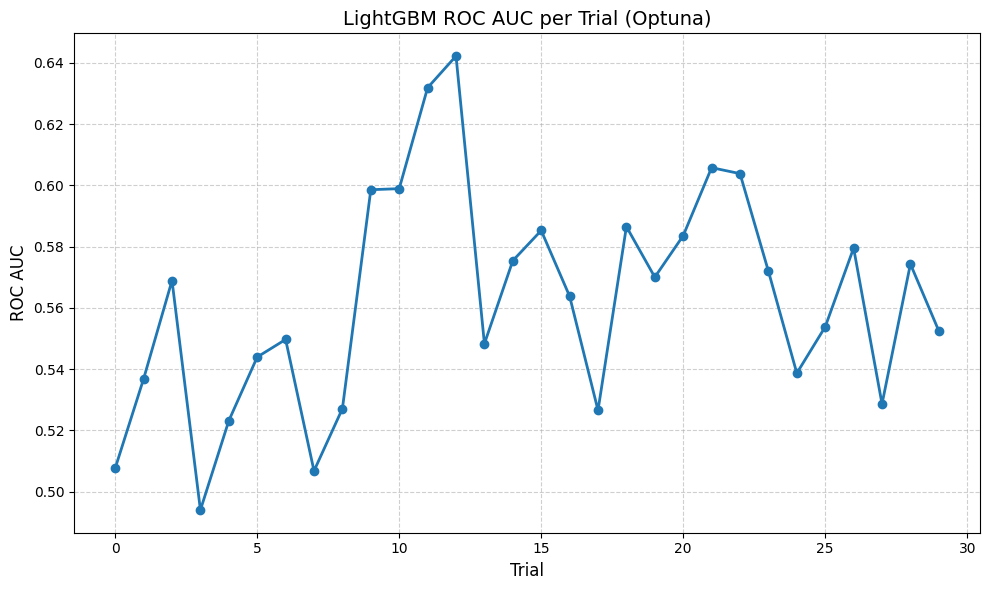

In [36]:
#  Save and plot trial AUC values
plt.figure(figsize=(10, 6))
plt.plot([t.value for t in lgb_study.trials], marker='o', linewidth=2)
plt.title('LightGBM ROC AUC per Trial (Optuna)', fontsize=14)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Saved/lightgbm_optuna_auc_plot.png", dpi=300, bbox_inches='tight')
plt.show()

Logistic regression with L1 is the current best. But that may reflect the nature of the data rather than the absolute superiority of the model.

## 4.5 Stacking (RF + LGBM + LR using Stacking Classifier)

Here’s a lean, production-ready template for tuning a 3-level stack (Random Forest + LightGBM as base learners, Logistic Regression as meta-learner) with Optuna, a tqdm progress bar, and full artifact saving.

Level-0 (base learners):

- RF averages many deep, decorrelated trees → low-variance
- LGBM builds trees sequentially to correct previous errors → low-bias, good at capturing complex interactions

Level-1 (meta learner) -- Logistic Regression (LR): 
- Learns how much to trust each base model for every region of feature space. With the raw features passed through, LR can up-weight one model when certain predictors are present and down-weight it elsewhere.


Because the two level-0 learners make uncorrelated errors, LR can often find decision boundaries in the 2-D “prediction space” (RF_prob, LGBM_prob) that neither original model could draw on its own, nudging borderline cases across the 0.5 threshold and lifting ROC-AUC by a few points.

Optimising stack: 100%|██████████| 30/30 [8:54:41<00:00, 1069.40s/it]  
c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Best AUC : 0.6568


c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


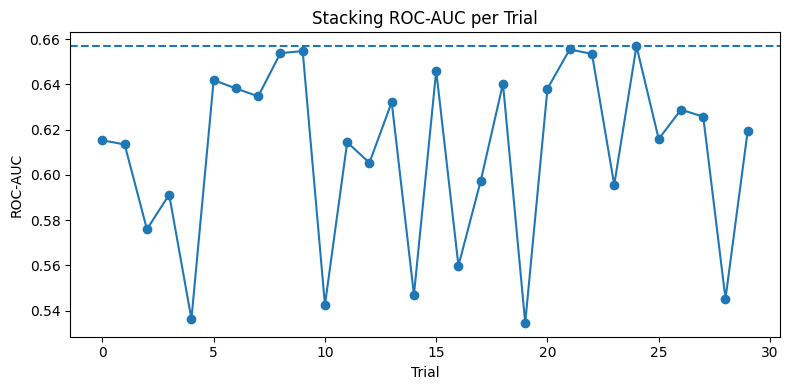

In [ ]:



# ----------------- 0.  Load best-param JSONs ------------------
param_dir = Path("Saved")

with (param_dir/"lightgbm_optuna_best_params.json").open() as f:
    lgb_base = json.load(f)          

with (param_dir/"random_forest_optuna_best_params.json").open() as f:
    rf_base = json.load(f)          

with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
    lr_base = json.load(f)          

# ----------------- 1. CV splitter ------------------
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------- 2. Optuna objective ------------------
def stack_objective(trial):
    # --- base learners (inner jobs **single-thread**)
    rf = RandomForestClassifier(**rf_base, n_jobs=1, random_state=42)
    lgbm = lgb.LGBMClassifier(**lgb_base, n_jobs=1, random_state=42)

    # --- meta learner: tune only a few high-impact params
    C = trial.suggest_float("lr_C", 1e-3, 10.0, log=True)
    pen = trial.suggest_categorical("lr_penalty", ["l1", "l2"])

    lr_params = lr_base.copy()
    lr_params.update(
        C=C,
        penalty=pen,
        solver="saga",
        n_jobs=1,
        max_iter=4000,
        random_state=42,
    )

    lr = LogisticRegression(**lr_params)

    stack = StackingClassifier(
        estimators=[('rf', rf), ('lgbm', lgbm)],
        final_estimator=lr,
        passthrough=True,          # feed original features to meta learner
        cv=5,                      # internal CV for meta features
        n_jobs=1                   # keep inner layer single-threaded
    )

    # outer CV parallelised – only one level of parallelism
    auc = cross_val_score(stack, X_train, y_train,
                          cv=cv_outer,
                          scoring="roc_auc",
                          n_jobs=-1).mean()
    return auc

# ----------------- 3.  Run study -----------------------
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)
study   = optuna.create_study(direction="maximize",
                              sampler=sampler,
                              study_name="Stack_RF_LGBM_LR")

with tqdm(total=30, desc="Optimising stack") as pbar:
    study.optimize(stack_objective,
                   n_trials=30,
                   callbacks=[lambda s, t: pbar.update()])

print(f"Best AUC : {study.best_value:.4f}")

# ----------------- 4.  Train final model --------------------
best = study.best_params
rf_final  = RandomForestClassifier(**rf_base,  n_jobs=1, random_state=42)
lgb_final = lgb.LGBMClassifier(**lgb_base,     n_jobs=1, random_state=42)

# --- build a clean parameter set for the meta-learner
lr_params = lr_base.copy()            # start from the Optuna-best L1 baseline
lr_params.update(
    C=best["lr_C"],                  # overwrite the tuned values …
    penalty=best["lr_penalty"],
    solver="saga",                   # keep the solver compatible with L1/L2
    n_jobs=1,
    max_iter=4000,
    random_state=42,
)

lr_final = LogisticRegression(**lr_params)

final_stack = StackingClassifier(
    estimators=[("rf", rf_final), ("lgbm", lgb_final)],
    final_estimator=lr_final,
    passthrough=True,
    cv=5,
    n_jobs=-1                # only here we parallelise prediction
).fit(X_train, y_train)

# ----------------- 5.  Persist artefacts --------------------
param_dir.mkdir(exist_ok=True)
joblib.dump(study,       param_dir/"stack_study.pkl")
joblib.dump(final_stack, param_dir/"stack_model.pkl")
with (param_dir/"stack_best_params.json").open("w") as f:
    json.dump(best, f, indent=2)

pd.DataFrame({
    "trial": [t.number for t in study.trials],
    "auc"  : [t.value  for t in study.trials]
}).to_csv(param_dir/"stack_trial_scores.csv", index=False)

# Optional plot
plt.figure(figsize=(8,4))
plt.plot([t.value for t in study.trials], marker="o")
plt.axhline(study.best_value, ls="--")
plt.title("Stacking ROC-AUC per Trial"); plt.xlabel("Trial"); plt.ylabel("ROC-AUC")
plt.tight_layout(); plt.savefig(param_dir/"stack_trials.png", dpi=300); plt.show()

No complementary signal: RF and LGBM aren’t adding information that LR-L1 doesn’t already capture. The meta-learner is just blending noise with a strong predictor → dilution of AUC.

| Model                        | Best ROC AUC | Notes                                   |
| ---------------------------- | ------------ | --------------------------------------- |
| **Logistic Regression (L1)** | **0.675**    | Highest score; simpler model            |
| Stacking ensemble (RF + LGBM + LR)| 0.6568  | Second-best                             |
| LightGBM + Optuna            | 0.6423       | fast and scalable                       |
| XGBoost + Optuna             | 0.6393       | Slightly behind LightGBM                |
| Random Forest + Optuna       | 0.6117       | Lowest; stable but less performant here |



# 5. SHAP Analysis

Among Logistic Regression, Random Forest, XGBoost, LightGBM, and the stacking ensemble of all three, the L1-regularized Logistic Regression model achieved the best performance.

In [8]:
param_dir = Path("Saved")
with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
    lr_l1_best = json.load(f)    

lr_l1_best_model = LogisticRegression(**lr_l1_best)
lr_l1_best_model.fit(X_train, y_train)

c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Sheng Miao\anaconda3\envs\ds_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.38045229148528126, class_weight='balanced',
                   max_iter=3000, penalty='l1', random_state=42, solver='saga')

In [9]:
# Save the model
joblib.dump(lr_l1_best_model, 'Saved/lr_l1_best_model_1.joblib')

['Saved/lr_l1_best_model_1.joblib']

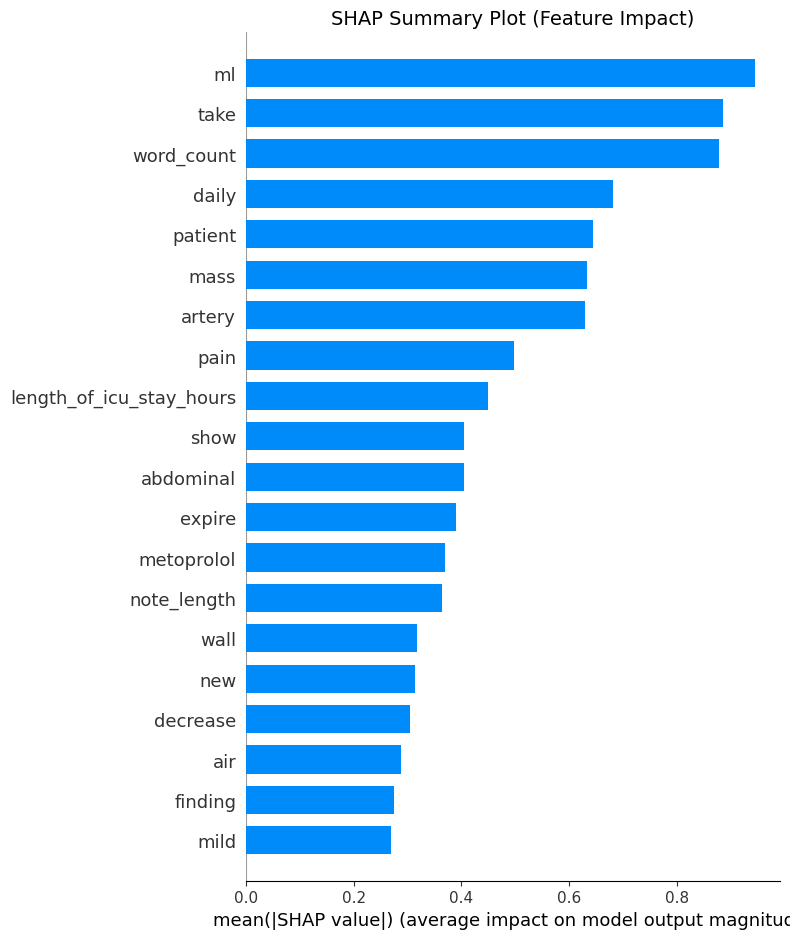

In [25]:
# 1. Create SHAP explainer and compute SHAP values
# -------------------------------------------------------------------
explainer = shap.LinearExplainer(lr_l1_best_model, X_train)
shap_values = explainer(X_train)

# -------------------------------------------------------------------
# 2. Global Feature Importance plot
# -------------------------------------------------------------------
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Feature Impact)", fontsize=14)
plt.savefig('Saved/lr_l1_SHAP_Summary_bar_Plot.png', dpi=300, bbox_inches="tight")
plt.subplots_adjust(bottom=0.8)
plt.tight_layout()
plt.show()


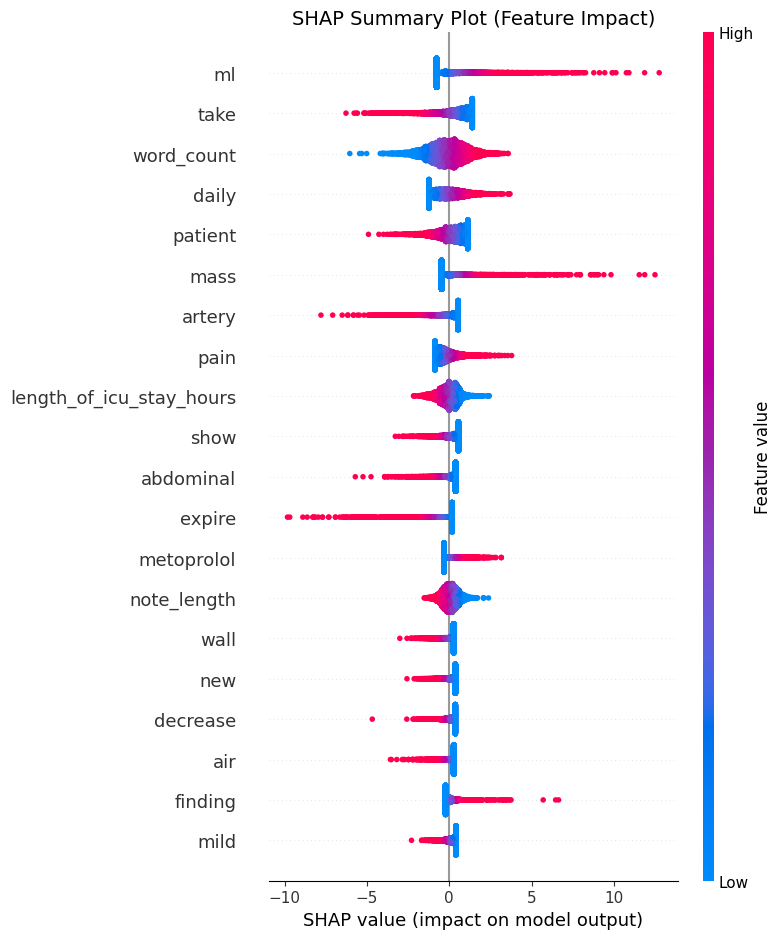

In [ ]:
# full beeswarm plot
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot (Feature Impact)", fontsize=14)
plt.savefig('Saved/lr_l1_SHAP_Summary_Plot.png', dpi=300, bbox_inches="tight")
plt.subplots_adjust(bottom=0.8)
plt.tight_layout()
plt.show()


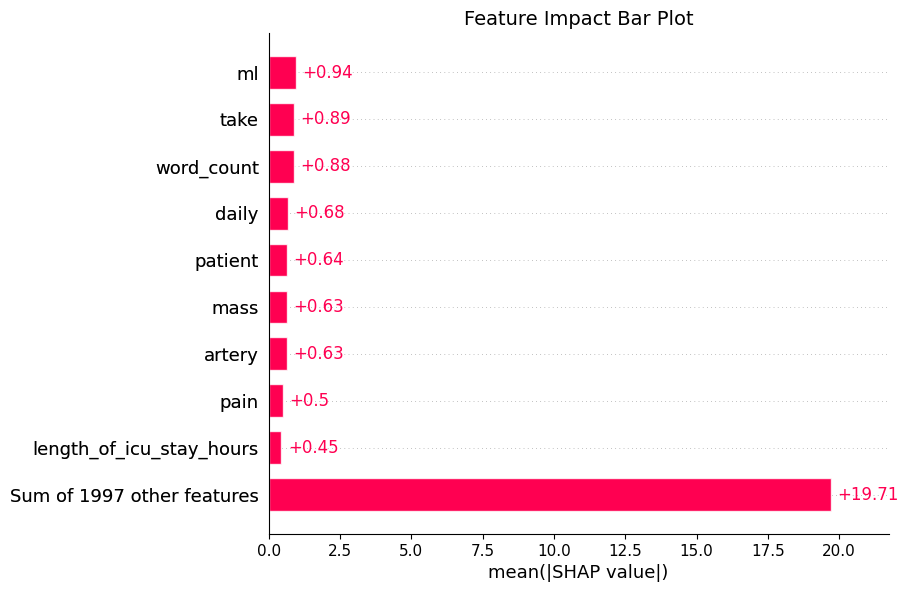

In [22]:
# Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values, show=False)
plt.title("Feature Impact Bar Plot", fontsize=14)
plt.savefig('Saved/lr_l1_SHAP_Bar_Plot.jpg', dpi=300, bbox_inches="tight")
plt.show()